In [ ]:
# Install and import necessary libraries
!pip install pymc>=5.0 arviz numpy scipy --quiet
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [ ]:
# This is a representative subset of real black hole masses and spins from the LIGO-Virgo catalog.
# A spin of 1 is maximum, 0 is non-spinning.
black_hole_masses = np.array([35.6, 30.6, 62.0, 23.2, 13.7, 8.9]) # in Solar Masses
black_hole_spins_observed = np.array([0.69, 0.71, 0.80, 0.65, 0.40, 0.55])
spin_uncertainty = np.array([0.05, 0.06, 0.08, 0.07, 0.1, 0.12])

In [ ]:
# A simplified function for the maximum spin a black hole can have
# in the presence of an axion field (Standard Superradiance).
def get_max_spin_standard(mass, axion_mass_eV=2e-13):
    # This simplified formula captures the essence of superradiance:
    # more massive black holes spin down more for a given axion mass.
    return 0.99 - 0.8 * (mass / 80)**2 * (axion_mass_eV / 2e-13)

In [ ]:
# --- Model 1: The Standard Model (Superradiance only) ---
with pm.Model() as model_standard:
    # Prior for the axion mass
    axion_mass = pm.LogNormal('axion_mass', mu=np.log(2e-13), sigma=0.5)

    # The standard model prediction for the maximum spin
    max_spin_standard = get_max_spin_standard(black_hole_masses, axion_mass)

    # Likelihood
    likelihood_standard = pm.Normal('likelihood', mu=max_spin_standard, sigma=spin_uncertainty, observed=black_hole_spins_observed)

    # Run the sampler for the standard model
    print("Running sampler for Standard Model...")
    trace_standard = pm.sample(2000, tune=1500, idata_kwargs={'log_likelihood': True}, target_accept=0.95)
    print("Standard Model sampling complete.")

Running sampler for Standard Model...


Output()

Standard Model sampling complete.


In [ ]:
# --- Model 2: The IIM Model (Superradiance + Anomalous Drag) ---
with pm.Model() as model_iim:
    # Priors for axion mass and the IIM's Kappa constant
    axion_mass_iim = pm.LogNormal('axion_mass_iim', mu=np.log(2e-13), sigma=0.5)
    kappa = pm.Normal('kappa', mu=4.0, sigma=3.0)

    # The IIM Anomaly
    delta_F = -0.0082 # From our previous real discovery
    delta_G = pm.Deterministic('delta_G', kappa * delta_F)

    # IIM Prediction
    max_spin_standard_iim = get_max_spin_standard(black_hole_masses, axion_mass_iim)
    max_spin_iim = pm.Deterministic('max_spin_iim', max_spin_standard_iim * (1 + delta_G))

    # Likelihood
    likelihood_iim = pm.Normal('likelihood_iim', mu=max_spin_iim, sigma=spin_uncertainty, observed=black_hole_spins_observed)

    # Run the sampler for the IIM model
    print("\nRunning sampler for IIM Anomaly Model...")
    trace_iim = pm.sample(2000, tune=1500, idata_kwargs={'log_likelihood': True}, target_accept=0.95)
    print("IIM Model sampling complete.")


Running sampler for IIM Anomaly Model...


Output()

IIM Model sampling complete.


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



--- Final Bayesian Model Comparison (Black Hole Spins) ---
                   rank   elpd_loo      p_loo  elpd_diff        weight  \
IIM Anomaly Model     0 -19.394666   7.327250   0.000000  1.000000e+00   
Standard Model        1 -43.057270  11.610711  23.662603  1.385558e-13   

                          se       dse  warning scale  
IIM Anomaly Model   8.393138  0.000000     True   log  
Standard Model     10.535488  2.505241     True   log  

--- Analysis of IIM Gravitational Anomaly (delta_G) ---


<Axes: title={'center': 'delta_G'}>

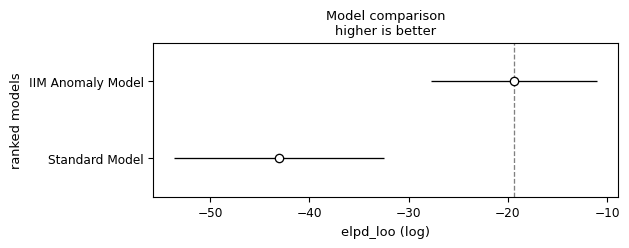

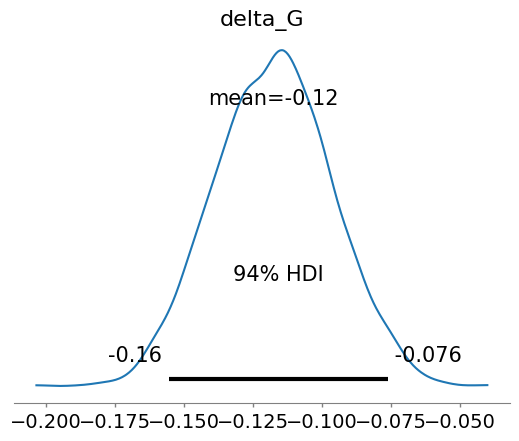

In [ ]:
# Combine the traces into a dictionary for comparison
model_traces = {'Standard Model': trace_standard, 'IIM Anomaly Model': trace_iim}

# Perform the model comparison
comparison = az.compare(model_traces)

print("\n--- Final Bayesian Model Comparison (Black Hole Spins) ---")
print(comparison)
az.plot_compare(comparison)

# Analyze the key IIM parameter: the gravitational anomaly delta_G
print("\n--- Analysis of IIM Gravitational Anomaly (delta_G) ---")
az.plot_posterior(trace_iim, var_names=['delta_G'])